In [380]:
import cv2
import numpy as np
import skimage
from skimage import filters
from skimage import morphology
import matplotlib.pyplot as plt
from skimage import transform as tf
from skimage.feature import match_template
%matplotlib inline

def plot_img(img, cmap='gray'):
    #plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [499]:
def match_pipeline(img, query):
    # Initiate SIFT detector
    # pip install opencv-contrib-python
    image = np.copy(img)
    sift = cv2.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_query, des_query = sift.detectAndCompute(query, None)
    kp_img, des_img = sift.detectAndCompute(image, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    try:
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_query, des_img, k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m, n in matches:
            if m.distance < 1.0 * n.distance:
                good.append(m)

        MIN_MATCH_COUNT = 10
        if len(good) > MIN_MATCH_COUNT:
            src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_img[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h, w = query.shape
            pts = np.float32([ [0, 0], [0, h-1], [w-1, h-1], [w-1, 0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts, M)
            image = cv2.polylines(image, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
            return image, np.int32(dst)
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None
    except:
        return image, None

In [509]:
def get_dst_s(img_pad, query, window_h, window_w, stride):
    dst_s = []

    for y0 in range(0, img_pad.shape[0] - window_h - 1, stride[0]):
        for x0 in range(0, img_pad.shape[1] - window_w - 1, stride[1]):
            img_cut = np.copy(img_pad[y0:(y0 + window_h), x0:(x0 + window_w)])
            img_, dst = match_pipeline(img_cut, query)

            if dst is not None:
                xs = dst[:, 0][:, 0]
                ys = dst[:, 0][:, 1]
                match_h = np.max(ys) - np.min(ys)
                match_w = np.max(xs) - np.min(xs)
                plot_img(img_)

                if abs(match_h - query.shape[0]) < (query.shape[0] // 2)\
                                            and abs(match_w - query.shape[1]) < (query.shape[1] // 2):
                    dst_s.append((y0, x0, np.min(ys), np.min(xs), match_h, match_w, dst))
                    #plot_img(img_)
                    #print(match_h, match_w)
    return dst_s

def get_boxes(dst_s):
    boxes = []
    areas = []
    for i in range(len(dst_s)):
        y0 = dst_s[i][0]
        x0 = dst_s[i][1]
        y_min = dst_s[i][2]
        x_min = dst_s[i][3]
        h = dst_s[i][4]
        w = dst_s[i][5]

        dst = np.array([[[x0+x_min, y0+y_min]],
                        [[x0+x_min+w, y0+y_min]],
                        [[x0+x_min+w, y0+y_min+h]],
                        [[x0+x_min, y0+y_min+h]]])
        #areas.append(cv2.contourArea(np.int32(dst)))
        boxes.append([x0+x_min, y0+y_min, x0+x_min+w, y0+y_min+h])
    return np.array(boxes)


def get_areas(boxes):
    areas = []
    for box in boxes:
        dst = np.array([[[box[0], box[1]]],
                        [[box[2], box[1]]],
                        [[box[2], box[3]]],
                        [[box[0], box[3]]]])
        areas.append(cv2.contourArea(np.int32(dst)))
    return np.array(areas)

In [381]:
def remove_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobel_mag = np.sqrt(sum([filters.sobel(gray, axis=i)**2
                             for i in range(gray.ndim)]) / gray.ndim)
    bin_sobel_mag  = sobel_mag > 0.1

    kernel1 = np.ones((3, 3), 'uint8')
    kernel2 = np.ones((7, 7), 'uint8')

    erode_img = bin_sobel_mag.astype('uint8')
    dilate_img = cv2.dilate(erode_img, kernel2, iterations=1)

    contours, hierarchy = cv2.findContours(dilate_img.astype('uint8'), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(cnt) for cnt in contours]

    index = np.argmax(areas)

    rect = cv2.minAreaRect(contours[index])

    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
    box = np.int0(box)
    distances = [np.linalg.norm(point) for point in box]
    if np.argmin(distances) == 1:
        box = box[[1, 2, 3, 0]]
    w = np.sqrt(np.sum((box[1] - box[0])**2))
    h = np.sqrt(np.sum((box[2] - box[1])**2))

    w = int(w)
    h = int(h)

    src = np.array([[0, 0], [0, w], [h, w], [h, 0]])
    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, box)
    result_table = tf.warp(img, tform3, output_shape=(w, h))

    #plt.imshow(result_table)
    
    return result_table

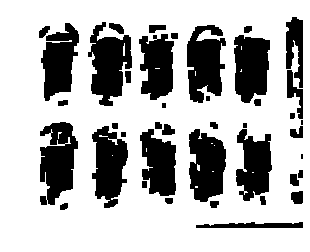

In [543]:
img_path = 'pills/pills/01.jpg' # 3, 8, 10, 14, 15
img = cv2.imread(img_path)
new = remove_edges(img)[20:-20, 30:-30]

new *= 255
new = new.astype('uint8')
gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
sobel_mag = np.sqrt(sum([filters.sobel(gray, axis=i)**2
                                 for i in range(gray.ndim)]) / gray.ndim)
bin_sobel_mag  = sobel_mag > 0.05
#plot_img(bin_sobel_mag)

#kernel1 = np.ones((3, 3), 'uint8')
#kernel2 = np.ones((5, 5), 'uint8')

kernel1 = np.ones((7, 7), 'uint8')
kernel2 = np.ones((10, 10), 'uint8')

erode_img = bin_sobel_mag.astype('uint8')
dilate_img = cv2.dilate(erode_img, kernel1, iterations=1)
erode = cv2.erode(dilate_img, kernel2, iterations=1)

if np.sum(1 - erode) < np.sum(erode):
    erode = 1 - erode
plot_img(1 - erode)

In [572]:
contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
output = erode.copy()

if len(contours) != 0:
    # the contours are drawn here
    cv2.drawContours(output, contours, -1, 255, 3)

    #find the biggest area of the contour
    c = max(contours, key = cv2.contourArea)

    x, y, w, h = cv2.boundingRect(c)
    # draw the 'human' contour (in green)
    template = new[y:y+h, x:x+w]
    
    cv2.rectangle(output,(x,y), (x+w,y+h), (255,255,0), 5)

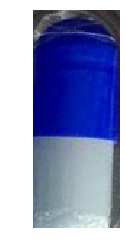

In [573]:
plot_img(template[15:-15,15:-15])
template = template[15:-15,15:-15]

In [574]:
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
window_h = int(gray_template.shape[0] * 2.5)
window_w = int(gray_template.shape[1] * 2.5)

In [575]:
new_image_width = gray.shape[1] + window_w
new_image_height = gray.shape[0] + window_h
img_pad = np.zeros((new_image_height, new_image_width), dtype=np.uint8)

# compute center offset
x_center = (new_image_width - gray.shape[1]) // 2
y_center = (new_image_height - gray.shape[0]) // 2

# copy image into center of result image
img_pad[y_center:y_center+gray.shape[0], 
        x_center:x_center+gray.shape[1]] = gray

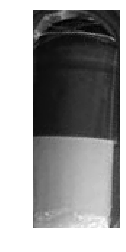

In [576]:
plot_img(gray_template)

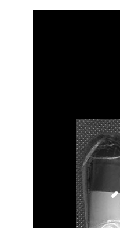

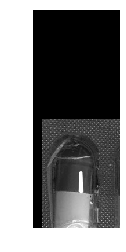

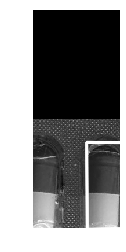

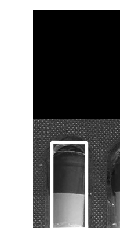

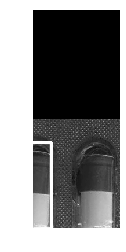

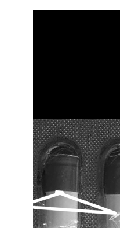

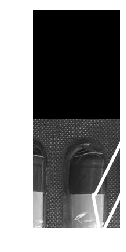

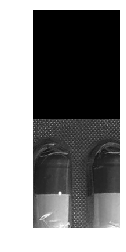

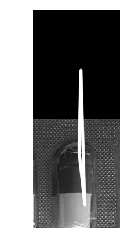

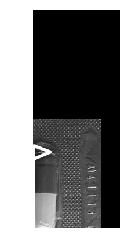

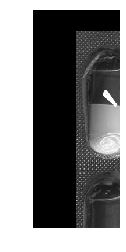

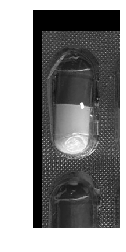

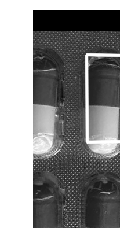

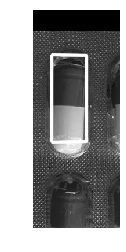

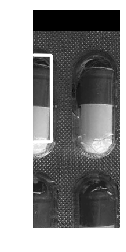

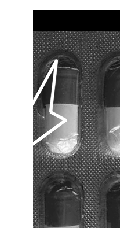

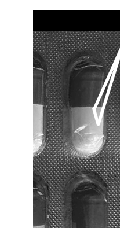

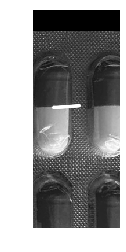

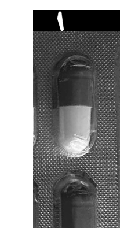

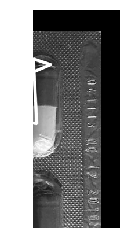

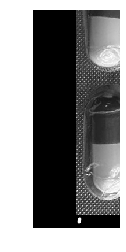

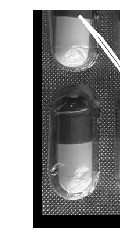

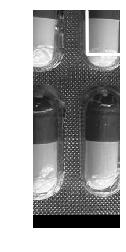

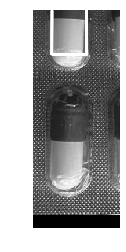

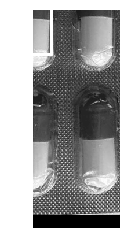

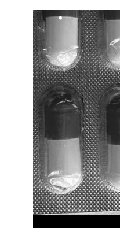

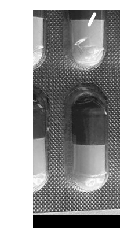

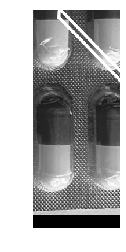

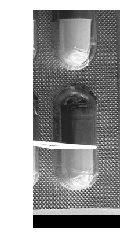

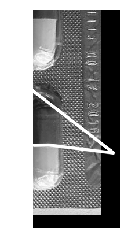

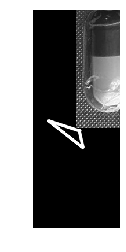

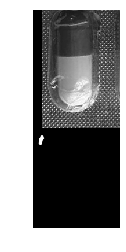

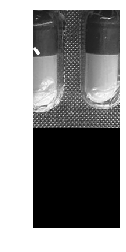

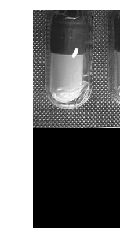

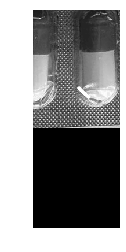

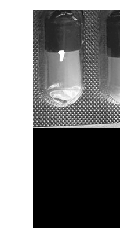

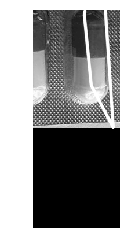

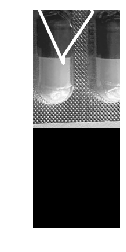

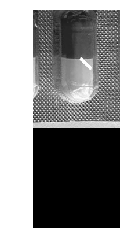

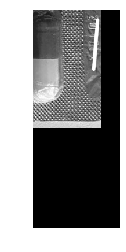

In [577]:
stride=(int(gray_template.shape[0]), int(gray_template.shape[1]))
dst_s_1 = get_dst_s(img_pad, gray_template, window_h, window_w, stride)

In [578]:
boxes_1 = get_boxes(dst_s_1)
area_1 = get_areas(boxes_1)

In [579]:
img_copy = np.copy(img_pad)
for box in boxes_1:
    dst = np.array([[[box[0], box[1]]],
                    [[box[2], box[1]]],
                    [[box[2], box[3]]],
                    [[box[0], box[3]]]])
    cv2.polylines(img_copy, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

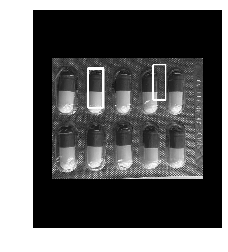

In [580]:
plot_img(img_copy)

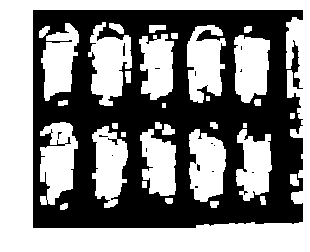

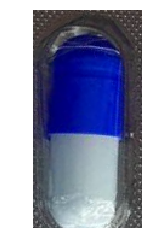

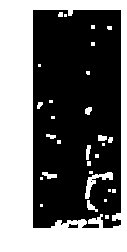

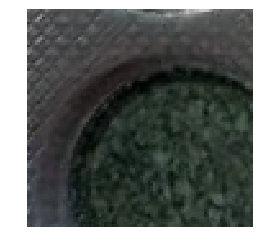

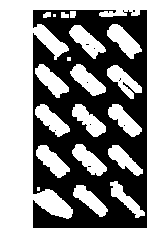

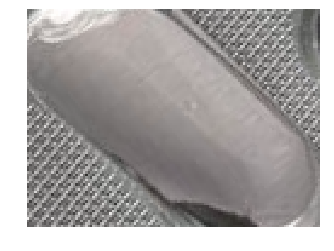

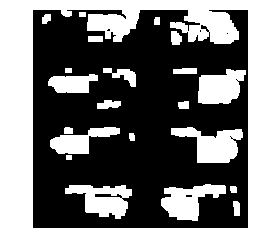

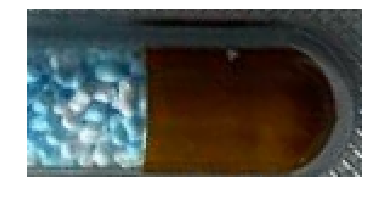

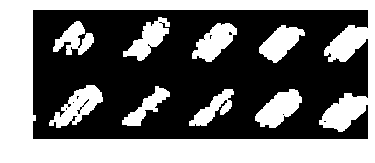

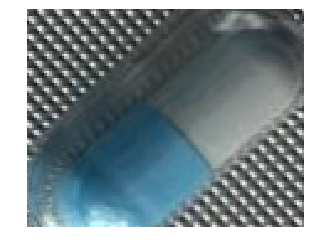

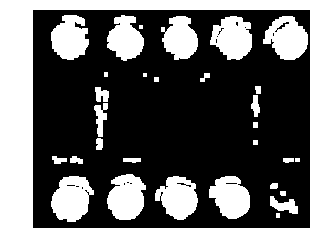

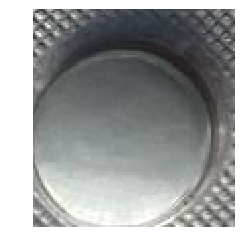

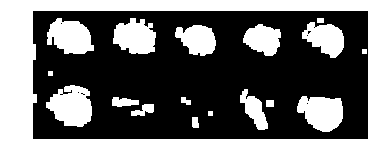

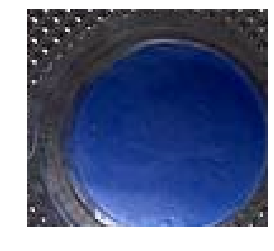

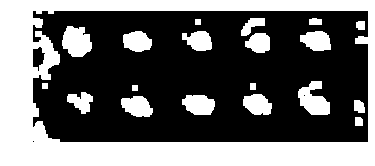

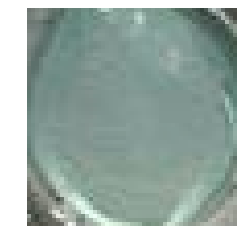

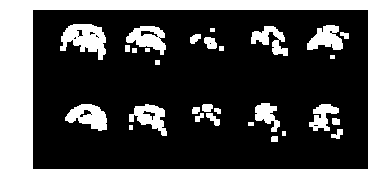

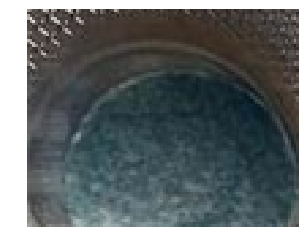

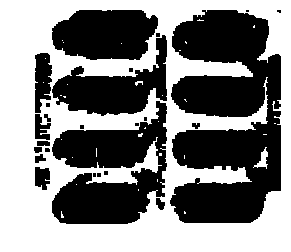

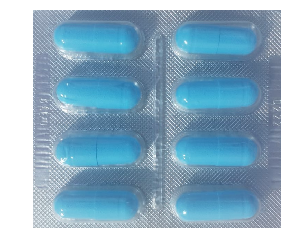

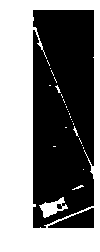

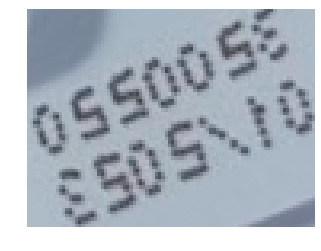

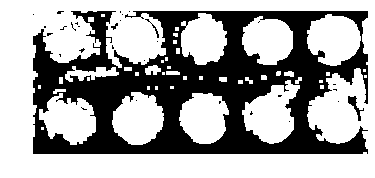

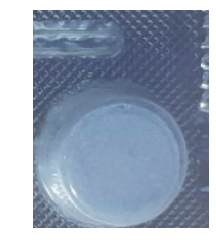

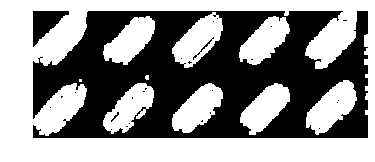

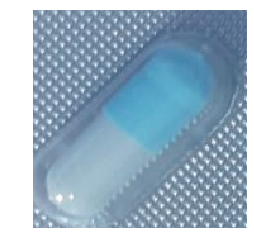

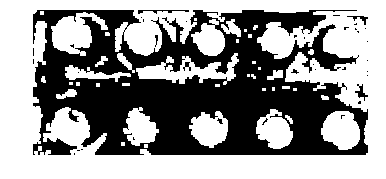

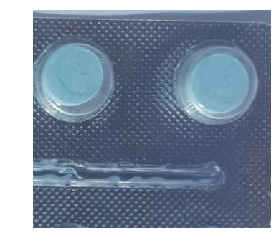

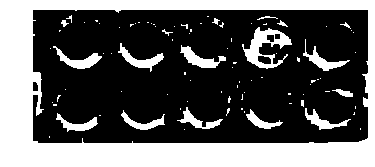

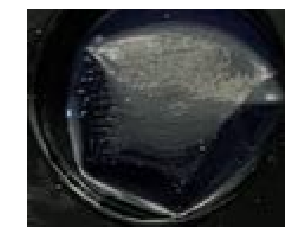

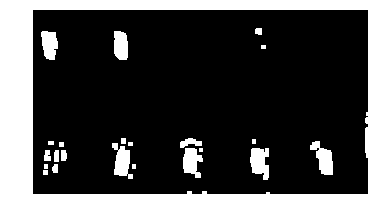

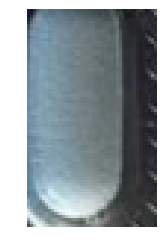

In [379]:
for file in ['01', '02', '03', '04', '05', '06', '07', '08',
     '09', '10', '11', '12', '13', '14', '15', '16']:
    img_path = 'pills/pills/'+file+'.jpg' # 3, 8, 10, 14, 15
    img = cv2.imread(img_path)
    new = remove_edges(img)[20:-20, 30:-30]

    new *= 255
    new = new.astype('uint8')
    gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
    sobel_mag = np.sqrt(sum([filters.sobel(gray, axis=i)**2
                                     for i in range(gray.ndim)]) / gray.ndim)
    bin_sobel_mag  = sobel_mag > 0.05
    #plot_img(bin_sobel_mag)

    #kernel1 = np.ones((3, 3), 'uint8')
    #kernel2 = np.ones((5, 5), 'uint8')

    kernel1 = np.ones((7, 7), 'uint8')
    kernel2 = np.ones((10, 10), 'uint8')

    erode_img = bin_sobel_mag.astype('uint8')
    dilate_img = cv2.dilate(erode_img, kernel1, iterations=1)
    erode = cv2.erode(dilate_img, kernel2, iterations=1)

    if np.sum(1 - erode) < np.sum(erode):
        erode = 1 - erode
    plot_img(erode)
    
    
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    output = erode.copy()

    if len(contours) != 0:
        # the contours are drawn here
        cv2.drawContours(output, contours, -1, 255, 3)

        #find the biggest area of the contour
        c = max(contours, key = cv2.contourArea)

        x, y, w, h = cv2.boundingRect(c)
        # draw the 'human' contour (in green)
        template = new[y:y+h, x:x+w]
        plot_img(template)

In [448]:
#gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
#corr_skimage = match_template(gray, gray_template, pad_input=True)
#treshold = (corr_skimage > 0.4).astype('uint8')
#plot_img(treshold)